<a href="https://colab.research.google.com/github/zhangou888/NN/blob/main/GCN_vs_MLP_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GCN vs. MLP Comparison

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 kB 3.6 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.9 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
Processing...
Done!


GCN Test Accuracy: 0.7910
MLP Test Accuracy: 0.4820


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


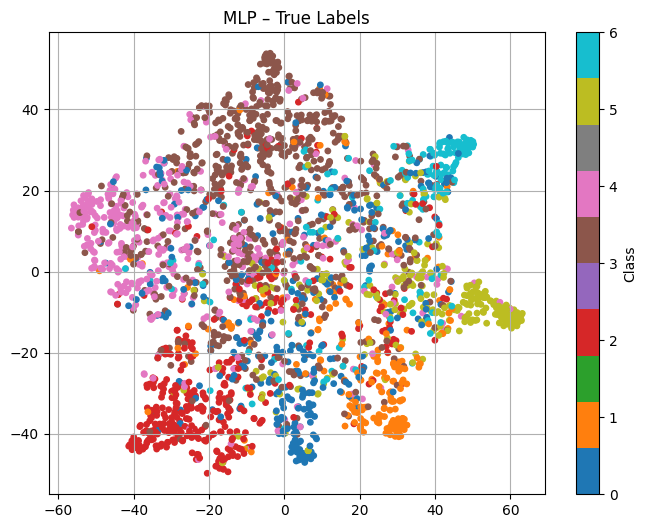

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


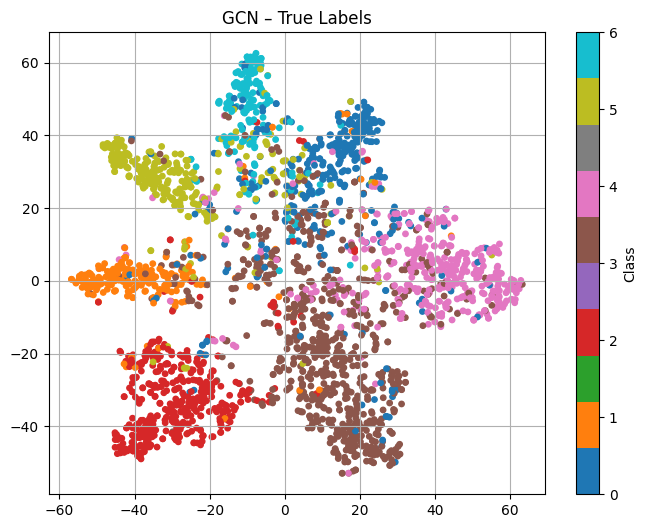

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


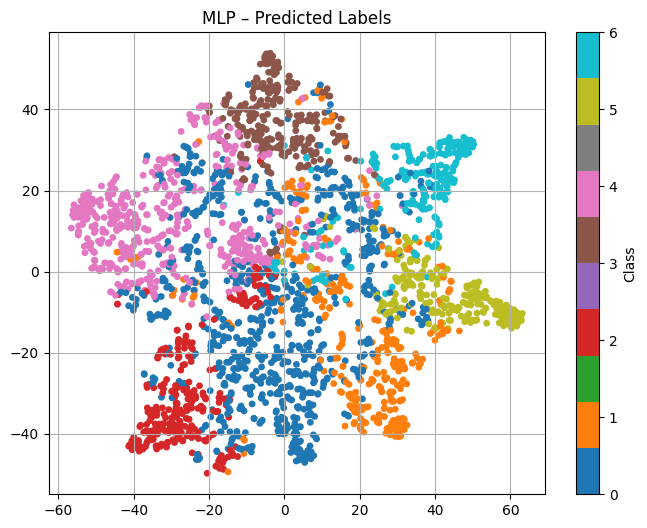

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


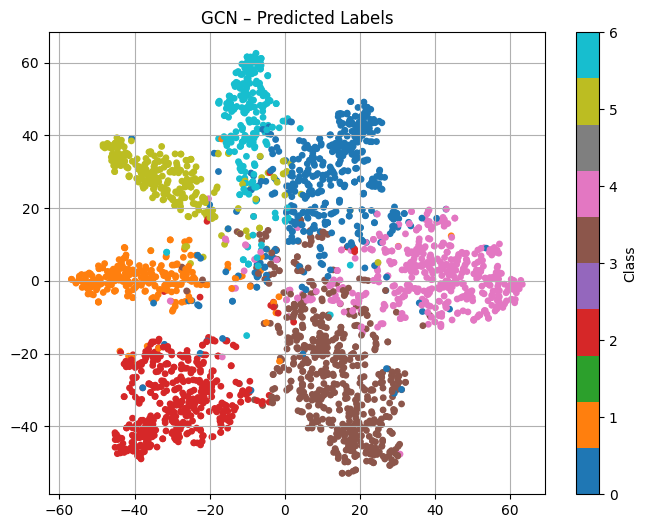

In [1]:
# Install necessary packages (for Colab)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install torch-geometric

# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load Cora dataset
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define MLP model
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dataset.num_node_features, 16)
        self.fc2 = nn.Linear(16, dataset.num_classes)

    def forward(self, data):
        x = data.x
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Utility: Train function
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Utility: Test function
def test(model):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

# Setup devices and data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

# Train GCN model
gcn_model = GCN().to(device)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(201):
    train(gcn_model, gcn_optimizer)

# Train MLP model
mlp_model = MLP().to(device)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)
for epoch in range(201):
    train(mlp_model, mlp_optimizer)

# Compare final accuracies
gcn_acc = test(gcn_model)
mlp_acc = test(mlp_model)
print(f'GCN Test Accuracy: {gcn_acc:.4f}')
print(f'MLP Test Accuracy: {mlp_acc:.4f}')

# Get embeddings (first layer outputs)
def get_hidden_embeddings(model):
    model.eval()
    with torch.no_grad():
        if isinstance(model, GCN):
            x = model.conv1(data.x, data.edge_index)
        else:
            x = model.fc1(data.x)
        return F.relu(x).cpu()

# t-SNE visualization
def visualize_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    embeddings_2d = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=labels.numpy(), cmap='tab10', s=15)
    plt.title(title)
    plt.colorbar(scatter, label='Class')
    plt.grid(True)
    plt.show()

# Visualize true labels and predictions
mlp_emb = get_hidden_embeddings(mlp_model)
gcn_emb = get_hidden_embeddings(gcn_model)

visualize_tsne(mlp_emb, data.y.cpu(), "MLP – True Labels")
visualize_tsne(gcn_emb, data.y.cpu(), "GCN – True Labels")

mlp_pred = mlp_model(data).argmax(dim=1).cpu()
gcn_pred = gcn_model(data).argmax(dim=1).cpu()

visualize_tsne(mlp_emb, mlp_pred, "MLP – Predicted Labels")
visualize_tsne(gcn_emb, gcn_pred, "GCN – Predicted Labels")
